# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** до 27 ноября 2017, 23:59   
**Штраф за опоздание:** -2 балла после 23:59  4 декабря, -4 балла после 23:59 11 декабря, -6 баллов после 23:59 18 декабря

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Разбаловка:**   
За задание можно получить 10 баллов. Для этого нужно следующее:
1. Там, где написано "Ваш код", нужно реализовать метод или часть метода
2. Там, где написано "Что делает этот блок кода?", нужно разобраться в блоке кода и в комментарии написать, что он делает    
3. Добиться, чтобы в пункте "Проверка скорости работы" Ваша реализация работала чуть быстрее, чем у дерева из sklearn
4. Добиться, чтобы в пункте "Проверка качества работы" Ваша реализация работала качественнее, чем у дерева из sklearn

In [1]:
from sklearn.tree import DecisionTreeClassifier
from time import time
from scipy import optimize

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print 'invalid criterion name'
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
            
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        
        else:
            print 'invalid max_features name'
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - np.sum( l_c**2 / l_s + r_c**2 / r_s, axis=1)
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        l_s = (l_s.astype('float'))
        r_s = (r_s.astype('float'))
        return -(np.sum(l_c * np.log((l_c + 1e-4) / l_s) + r_c * np.log((r_c + 1e-4) / r_s), axis=1)).reshape(-1, 1) / (l_s + r_s)

    def __misclass(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - np.max(l_c / (l_s + r_s), axis=1) - np.max(r_c / (l_s + r_s), axis=1)

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(sqrt(n_feature))]
        
    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        return range(n_feature)
    
    def __sort_samples(self, x, y): #сортируем вектор x и y по его значениям
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]


    def __div_samples(self, x, y, feature_id, threshold):
        
        #делим выборку на две по величине threshold для feature_id
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask] #x_left, x_right, y_left, y_right
  
    
    def __find_threshold(self, x, y):
        #получаем x и y, отсортированные по возрастанию x 
        sorted_x, sorted_y = self.__sort_samples(x, y)
        # я удалил следующую строчку и заменил везде class_number на self.num)_class, 
        # чтобы работало на данных с боллее, чем двумя классами
        #class_number = np.unique(y).shape[0]
        
        #места, где может быть разбиение, не нарушающее условия на минимальное число элементов в листе
        splitted_sorted_y = sorted_y[self.min_samples_split:-self.min_samples_split]
        #места, где меняются классы
        r_border_ids = np.where(splitted_sorted_y[:-1] != splitted_sorted_y[1:])[0] + (self.min_samples_split + 1)
        
        #если не меняются нигде
        if len(r_border_ids) == 0:
            return float('+inf'), None
        
        
        #число идущих подряд одинаковых индексов (кроме последнего)
        eq_el_count = r_border_ids - np.append([self.min_samples_split], r_border_ids[:-1])
        
        # [i,j] = 1, если i отрезок - имеет номер j
        one_hot_code = np.zeros((r_border_ids.shape[0], self.num_class))
        one_hot_code[np.arange(r_border_ids.shape[0]), sorted_y[r_border_ids - 1]] = 1
        
        # [i,j] = n, если i отрезок - имеет n элементов номера j
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        #добавляем, что отрезали в splitted_sorted_y
        class_increments[0] = class_increments[0] + np.bincount(sorted_y[:self.min_samples_split], minlength=self.num_class)
        
        #определяем, сколько элементов класса останется в правой и левой ветви при разьиении по каждой границе
        l_class_count = np.cumsum(class_increments, axis=0)        
        r_class_count = np.bincount(y, minlength=self.num_class) - l_class_count
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        r_sizes = sorted_y.shape[0] - l_sizes

        #ищем лучшее impurity 
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        idx = np.argmin(gs)
    
        #номер элемента, с которого начинается правый класс
        left_el_id = l_sizes[idx][0]
        #возвращаем impurity и усредненный threshold
        return gs[idx], (sorted_x[left_el_id-1] + sorted_x[left_el_id]) / 2.0

    
    def __fit_node(self, x, y, node_id, depth, pred_f=-1): 
        
        #достигнута максимальная глубина
        if depth == self.max_depth:
            #create leaf
            self.__create_leaf(y, node_id, depth, 'maxDepth')
            return
            
        #если размер меньше min_samples_split
        if x.shape[0] <= self.min_samples_split:
            #create leaf
            self.__create_leaf(y, node_id, depth, 'lessMinSplit')
            return
        
        #если присутствует только один класс
        if np.unique(y).shape[0] == 1:
            self.__create_leaf(y, node_id, depth, 'onlyOneClass')
            return
        
        #если доля какого-то класса > sufficient_share
        if np.max(1.0*np.bincount(y) / y.shape[0]) >= self.sufficient_share:
            self.__create_leaf(y, node_id, depth, 'suffShare')
            return
        
        #далее выбираем по какому признаку провести разделение
     
        #списки [признак х (impurity_measure, threshold)]
        imp = np.zeros(x.shape[1])
        threshold = np.zeros(x.shape[1])
        features = self.get_feature_ids(x.shape[1])
        
        for i in features:
            #поиск порогового значения для i-го признака
            imp_i, thr = self.__find_threshold(x[:,i], y)
            threshold[i] = thr
            imp[i] = imp_i
        
        #нам нужено найти разбиение с минимальным значением
        feature_id = argmin(imp)
        
        #если не получилось разделить - создаем лист
        if np.isnan(threshold[feature_id]):
            self.__create_leaf(y, node_id, depth, 'thr-nan')
            return
        
        #делим
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold[feature_id])
        
        #если одка из ветвей пустая - создаем лист
        if y_right.shape[0] == 0 or y_left.shape[0] == 0:
            self.__create_leaf(y, node_id, depth, 'oneIsEmpty')
            return
        
        #или создаем два потомка
        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold[feature_id], 'child')
        self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
   
                                                      
    #создать лист
    def __create_leaf(self, y, node_id, depth, crit=None):  
        counts = np.bincount(y, minlength=self.num_class)
        probs = counts / np.sum(counts).astype('float')
        self.tree[node_id] = (self.LEAF_TYPE, np.argmax(counts), probs, crit)
        
        
    def fit(self, x, y):
        self.num_class = np.unique(y).size #число классов
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold, _ = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

## Проверка на данных:

In [3]:
df = pd.read_csv('./cs-training.csv', sep=',').dropna()
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
x = df.as_matrix(columns=df.columns[1:])
y = df.as_matrix(columns=df.columns[:1])
y = y.reshape(y.shape[0])

In [5]:
clf = DecisionTreeClassifier()
my_clf = MyDecisionTreeClassifier()

## Проверка скорости работы

In [6]:
t1 = time()
my_clf.fit(x, y)
t2 = time()
print 'my_clf: ', (t2 - t1)

t1 = time()
clf.fit(x, y)
t2 = time()
print 'clf: ', (t2 - t1)

my_clf:  0.714000225067
clf:  1.66599988937


## Проверка качества работы

In [7]:
gkf = KFold(n_splits=5, shuffle=True)

### MyDecisionTreeClassifier:

In [8]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    my_clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.929866134531
0.929866134531
0.931695352124
0.934314459134
0.933771255145


### DecisionTreeClassifier из sklearn:

In [9]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

0.891452565062
0.891452565062
0.895069427122
0.894279537707
0.892196399618


В этом датасете доля одного класса составляет 93% от общего числа элементов. Поэтому не совсем корректно расчитывать accuracy_score. Например, для константного предсказания y_const = 0:

In [10]:
y_const = np.zeros(X_test.shape[0])
print(accuracy_score(y_const, y_test))

0.930985739825


Поэтому, будем тестировать корректность работы на blobs из sklearn:

In [11]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1233)

idx = range(1000)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X_train = X[500:]
y_train = y[500:]

X_test = X[:500]
y_test = y[:500]

### MyDecisionTreeClassifier:

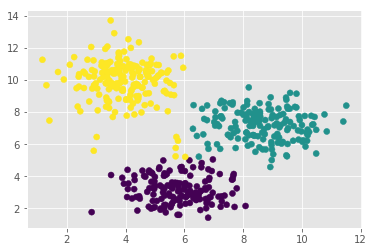

accuracy score:  0.98


In [12]:
my_clf = MyDecisionTreeClassifier(criterion='misclass')
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred)
plt.show()
print 'accuracy score: ', accuracy_score(y_test, y_pred)

### DecisionTreeClassifier из sklearn:

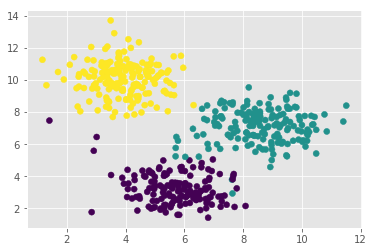

accuracy score:  0.978


In [13]:
my_clf = DecisionTreeClassifier()
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred)
plt.show()
print 'accuracy score: ', accuracy_score(y_test, y_pred)